<a href="https://colab.research.google.com/github/atharvakale31/PR_ML/blob/master/Programming_Probastically.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
np.random.seed(123)

In [ ]:
az.style.use('arviz-darkgrid')

Generating Synthetic data.

In [ ]:
trials = 4
theta_real = 0.35  # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0])


1.   For the likelihood, we will use the binomial distribution with n=1
and p = $\theta$
2.   for the prior, a beta distribution with the parameters $\alpha$=$\beta$=1



In [ ]:
with pm.Model() as our_first_model:
    # a priori
    θ = pm.Beta('θ', alpha=1., beta=1.)
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(1000, random_seed=123)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


In [ ]:
trace[0]

{'θ': 0.24505352995582733, 'θ_logodds__': -1.1251701698367444}

# Summarizing the posterior


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa05de6c8d0>,
      dtype=object)

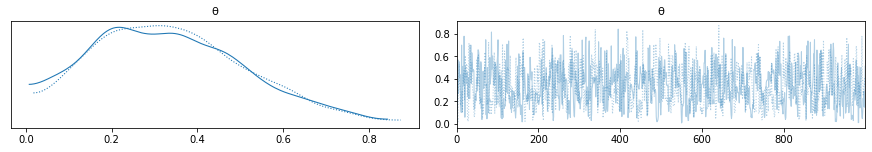

In [ ]:
az.plot_trace(trace)

In [ ]:
az.summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.336,0.178,0.019,0.654,0.006,0.005,710.0,718.0,1.0


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


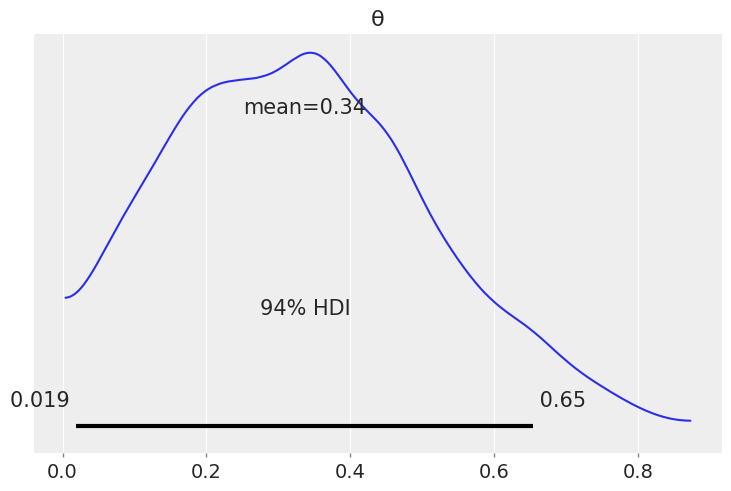

In [ ]:
az.plot_posterior(trace)

## Region Of Practical Equivalence (ROPE):
In practice, we can relax the definition of fairness and we can say that a fair coin is one with a value of around 0.5.   
For example, we could say that any value in the interval [0.45, 0.55] will be, for our purposes, practically equivalent to 0.5. We call this interval a Region Of Practical Equivalence.   
* The ROPE does not overlap with the HPD; we can say the coin is not fair.
* ROPE contains the entire HPD; we can say the coin is fair .
* The ROPE partially overlaps with HPD; we cannot say the coin is fair or unfair.

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


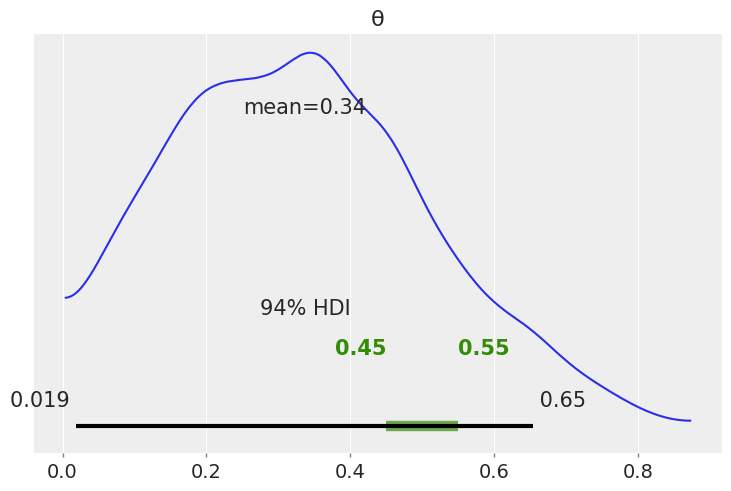

In [ ]:
az.plot_posterior(trace, rope=[0.45, .55])

Another tool we can use to help us make a decision is to compare the posterior against a reference value

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


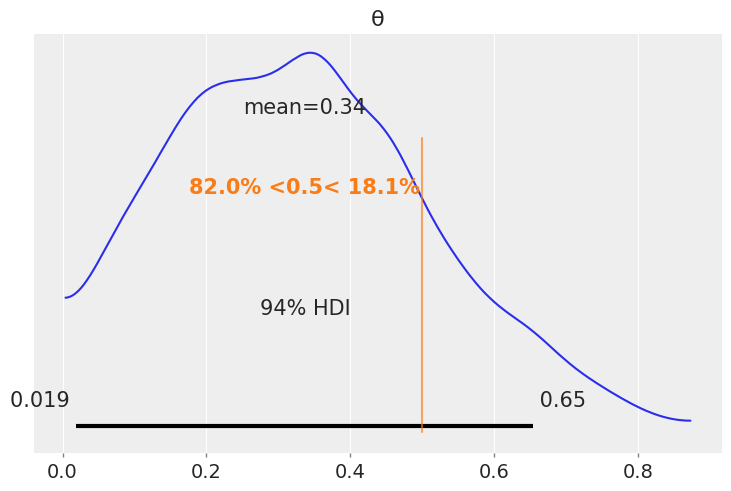

In [ ]:
az.plot_posterior(trace, ref_val=0.5)

# Loss Functions
The key idea is to use a function that captures how different the true value and the estimated value of a parameter are.
Eg Loss Fucntions:
* Quadratic Loss
* Absolute Loss 


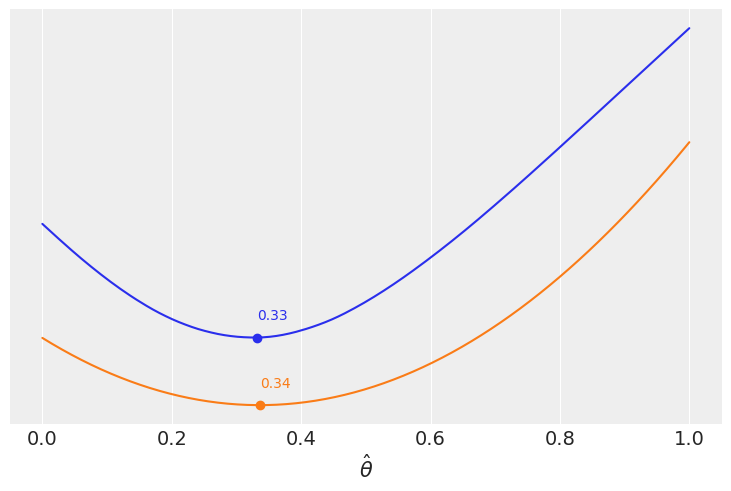

In [ ]:
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid] #absolute loss
lossf_b = [np.mean((i - θ_pos)**2) for i in grid] #quadratic loss

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')


What is interesting from this result is that the first value is equal to the median of the posterior and the last value is equal to the mean of the posterior.  
Different loss functions are related to different point-estimates

In [ ]:
np.mean(θ_pos), np.median(θ_pos)

NameError: ignored

* The advantage of explicitly choosing a loss function is that we can tailor the function to our problem, instead of using some predefined rule that may not be suitable in our particular case.
* Thus, if our problem demands it, we can construct an asymmetric loss function.

Text(0.5, 0, '$\\hat \\theta$')

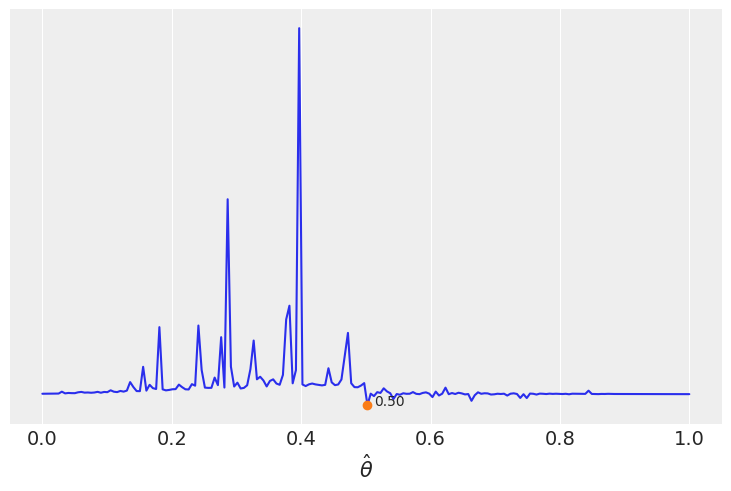

In [ ]:

lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos)) # pie * actual_val/(1-actual_val)
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')

(-5.0, 5.0)

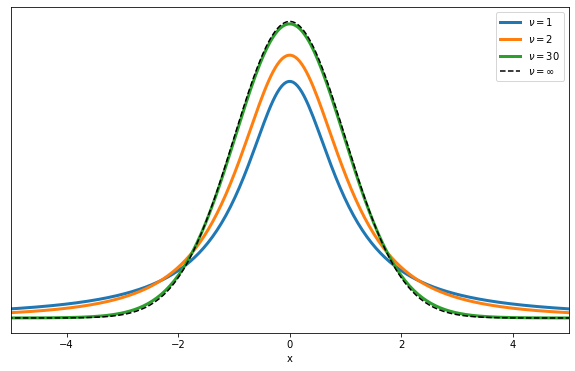

In [ ]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)